In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# warnings are not important :)
import warnings
warnings.filterwarnings('ignore')

In [9]:
# import graph module
import sys
sys.path.append("../../")
from tools.graph_tools import *
from oracles.minimization import *
from methods.gradient_tracking import *

In [10]:
X = np.array([1, 2])

In [11]:
def calc_delta_Fx(oracles, x):
    res = []
    for i in range(len(oracles)):
        res.append( oracles[i].grad(np.array([x[i,j] for j in range(2)])) )
    return np.matrix(res)

def calc_F(oracles, x):
    res = []
    for i in range(len(oracles)):
        res.append( oracles[i].func(np.array([x[i,j] for j in range(2)])) )
    return np.matrix(res)

def calc_error(oracles, x_curr, x_prev):
    return np.sum( abs(calc_F(oracles, x_curr) - calc_F(oracles, x_prev)) ) 

def _calc_error(oracles, x_curr, x_prev):
    return np.sum( abs(x_curr - np.array([2, 3])) )

In [12]:
# N = 50 - not good
N = 10
gx = []
for i in range(N):
    _x = x*random.random()
    # 10% not good, 5% - good :)
    gx.append(_x + [random.uniform(-_x[j]/20, _x[j]/20) for j in range(len(_x))])

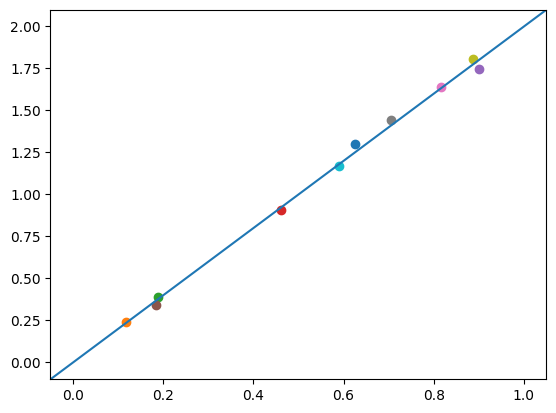

In [13]:
for x in gx:
    plt.plot(x[0], x[1], 'o')
plt.axline((0, 0), tuple(X))
plt.show()

In [14]:
oracles = []
for x in gx:
    A = np.array([[-x[1], x[0]],
                  [-x[1], x[0]+1/x[1]]])
    b = np.array([0, 1])
    oracles.append(LinearRegressionL2Oracle(A, b, regcoef=0.01))

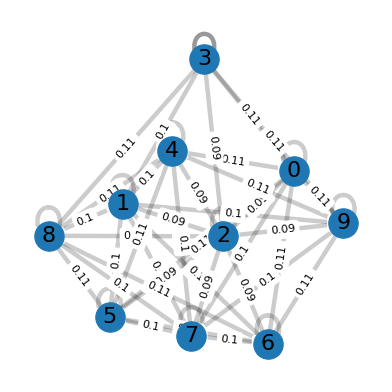

In [15]:
W = make_random_graph_matrix(N, 0.2)
W = fill_metropolis_weigts(W)
make_graph_img(W, fig_size=(5, 5))

In [86]:
alpha = 0.001
theta = 0.2
mu = 0.7

err = 0.01

In [87]:
x0 = np.full((N, 2), 2.5)

In [88]:
res = gradient_tracking(F = oracles,
                 f = oracles,
                 calc_delta_Fx = calc_delta_Fx,
                 calc_error = calc_error,
                 W = W,
                 x0 = x0,
                 alpha = alpha,
                 theta = theta,
                 mu = mu,
                 err = err,
                 max_iter = 10000,
                 need_log = False)

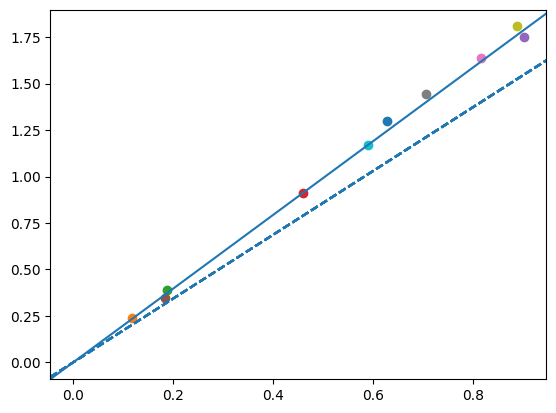

In [89]:
for x in gx:
    plt.plot(x[0], x[1], 'o')
for i in range(len(res)):
    plt.axline((0, 0), tuple([res[i,j] for j in range(2)]), linestyle='--', )
plt.axline((0, 0), tuple(x))
plt.show()